In [175]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from getdata import netflix_df

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [176]:
# Variables
min_rating = 7

# Create DataFrame
condensed_df = netflix_df.loc[netflix_df["imdb_score"] >= min_rating]
#condensed_df.head()

In [177]:
# Function to turn the "genre" list string into an actual list
def makeList(string):
    # Format the string and return it
    # re.sub() function taken from StackOverflow: https://stackoverflow.com/questions/34860982/replace-the-punctuation-with-whitespace
    clean = re.sub(r"[\[\]\' ]+\ *", "", string)
    clean2 = re.sub(r",", " ", clean)
    if clean2 == "":
        return []
    else:
        return list(clean2.split(" "))

In [178]:
# Create array for storing unique genres
genre_data = []

# Iterate over all rows
for index, row in condensed_df.iterrows():
    # Turn genre string into list
    genre_list = makeList(row["genres"])

    # Iterate over all genres found in the row
    for genre in genre_list:
        # Check if the genre has already been added to genre_data
        # If so, increment the "total" and either "movie" or "show" depending on the type
        # If not, append it to genre_data with appropriate starting values based on type
        if(row["type"] == "MOVIE"):
            if(not any(g["word"] == genre for g in genre_data)):
                genre_data.append({"word": genre, "total": 1, "movies": 1, "shows": 0})
            else:
                genre_data[next((index for (index, g) in enumerate(genre_data) if g["word"] == genre), None)]["total"] += 1
                genre_data[next((index for (index, g) in enumerate(genre_data) if g["word"] == genre), None)]["movies"] += 1
        else:
            if(not any(g["word"] == genre for g in genre_data)):
                genre_data.append({"word": genre, "total": 1, "movies": 0, "shows": 1})
            else:
                genre_data[next((index for (index, g) in enumerate(genre_data) if g["word"] == genre), None)]["total"] += 1
                genre_data[next((index for (index, g) in enumerate(genre_data) if g["word"] == genre), None)]["shows"] += 1

#genre_data

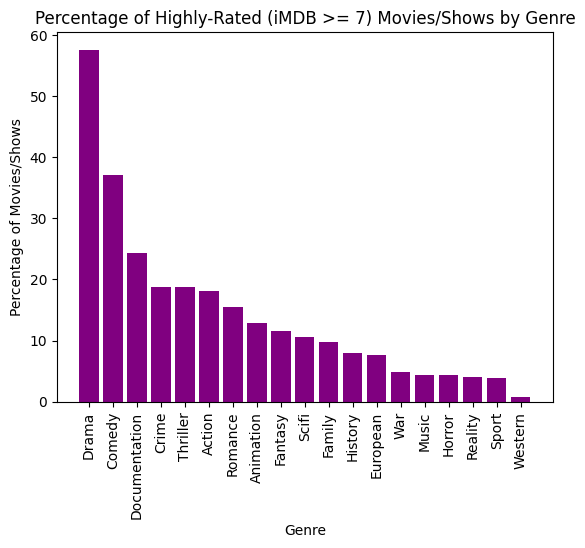

In [179]:
# Sort data by total
# sorted() function taken from StackOverflow: https://stackoverflow.com/questions/72899/how-to-sort-a-list-of-dictionaries-by-a-value-of-the-dictionary-in-python
sorted_total_data = sorted(genre_data, key=lambda x: x["total"], reverse=True)

# Get the total amount of movies, shows, and them combined
total_movies = condensed_df["type"].value_counts()["MOVIE"]
total_shows = condensed_df["type"].value_counts()["SHOW"]
total = total_movies + total_shows

# Set x-ticks
genres = [g["word"].capitalize() for g in sorted_total_data]

# Set x and y axes
x_axis = np.arange(len(genres))
y_axis = [(g["total"] / total) * 100 for g in sorted_total_data]

# Graph the combined genre percentages
plt.bar(x_axis, y_axis, color="purple")
plt.xticks(x_axis, genres, rotation=90)
plt.title(f"Percentage of Highly-Rated (iMDB >= {min_rating}) Movies/Shows by Genre")
plt.xlabel("Genre")
plt.ylabel("Percentage of Movies/Shows")
plt.show()

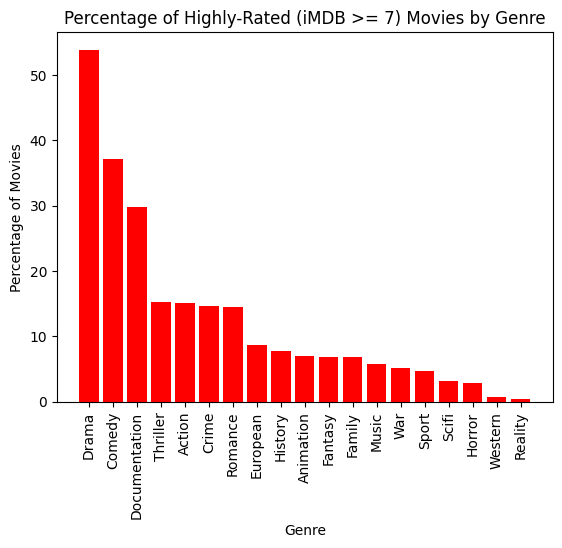

In [180]:
# Sort data by movies
# sorted() function taken from StackOverflow: https://stackoverflow.com/questions/72899/how-to-sort-a-list-of-dictionaries-by-a-value-of-the-dictionary-in-python
sorted_movie_data = sorted(genre_data, key=lambda x: x["movies"], reverse=True)

# Set x-ticks
genres = [g["word"].capitalize() for g in sorted_movie_data]

# Set x and y axes
x_axis = np.arange(len(genres))
y_axis = [(g["movies"] / total_movies) * 100 for g in sorted_movie_data]

# Graph the movie genre percentages
plt.bar(x_axis, y_axis, color="red")
plt.xticks(x_axis, genres, rotation=90)
plt.title(f"Percentage of Highly-Rated (iMDB >= {min_rating}) Movies by Genre")
plt.xlabel("Genre")
plt.ylabel("Percentage of Movies")
plt.show()

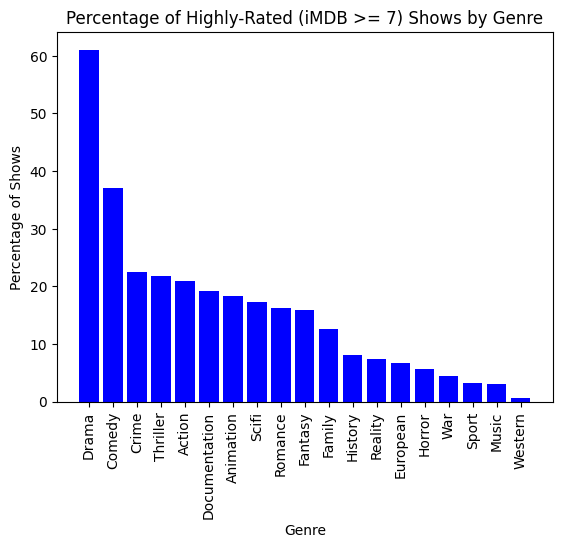

In [181]:
# Sort data by shows
# sorted() function taken from StackOverflow: https://stackoverflow.com/questions/72899/how-to-sort-a-list-of-dictionaries-by-a-value-of-the-dictionary-in-python
sorted_show_data = sorted(genre_data, key=lambda x: x["shows"], reverse=True)

# Set x-ticks
genres = [g["word"].capitalize() for g in sorted_show_data]

# Set x and y axes
x_axis = np.arange(len(genres))
y_axis = [(g["shows"] / total_shows) * 100 for g in sorted_show_data]

# Graph the show genre percentages
plt.bar(x_axis, y_axis, color="blue")
plt.xticks(x_axis, genres, rotation=90)
plt.title(f"Percentage of Highly-Rated (iMDB >= {min_rating}) Shows by Genre")
plt.xlabel("Genre")
plt.ylabel("Percentage of Shows")
plt.show()

In [182]:
# Movies and Shows Combined

# Create copy of condensed DataFrame and add new column
total_group_df = condensed_df.copy()
total_group_df["Popular Genres"] = ""

# List of genres we're searching for
popular_genres = ["action", "comedy", "crime", "drama", "documentation", "thriller"]

# Iterate over all movies/shows
for index, row in total_group_df.iterrows():
    # Turn the genres string into a sorted list
    genre_list = makeList(row["genres"])
    genre_list.sort()

    # Variables
    contains_genre = False
    popular_genres_string = ""

    # Iterate over genres we're searching for
    # If it exists, add it to string
    for genre in popular_genres:
        if genre in genre_list:
            popular_genres_string = popular_genres_string + genre + " / "
            contains_genre = True
    
    # Remove " / " at end of string
    popular_genres_string = popular_genres_string[:-3]
    
    # If exactly 2 genres were found in the list, add them to the new column
    # Otherwise, drop the row
    if contains_genre:
        if(popular_genres_string.count("/") == 0 or popular_genres_string.count("/") > 1):
            total_group_df.drop(index, inplace=True)
        else:
            total_group_df.at[index, "Popular Genres"] = popular_genres_string
    else:
        total_group_df.drop(index, inplace=True)

#total_group_df.head()


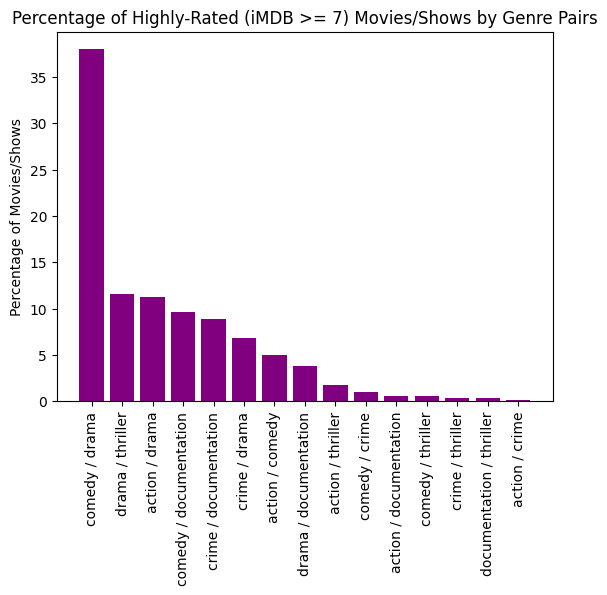

In [183]:
# Set x-axis
sorted_genre_groups = total_group_df.groupby(["Popular Genres"]).size().sort_values(ascending=False)
x_axis = np.arange(len(sorted_genre_groups))

# Set y-axis
genre_sum = sorted_genre_groups.sum()
y_axis = [(g / genre_sum) * 100 for g in sorted_genre_groups]

# Graph the combined genre pairs percentages
plt.bar(x_axis, y_axis, color="purple")
plt.xticks(x_axis, sorted_genre_groups.index, rotation=90)
plt.title(f"Percentage of Highly-Rated (iMDB >= {min_rating}) Movies/Shows by Genre Pairs")
plt.ylabel("Percentage of Movies/Shows")
plt.show()

In [184]:
# Movies Only

# Create DataFrame with only movies and add new column
movies_group_df = condensed_df.loc[condensed_df["type"] == "MOVIE"]
movies_group_df["Popular Genres"] = ""

# Iterate over all movies/shows
for index, row in movies_group_df.iterrows():
    # Turn the genres string into a sorted list
    genre_list = makeList(row["genres"])
    genre_list.sort()

    # Variables
    contains_genre = False
    popular_genres_string = ""

    # Iterate over genres we're searching for
    # If it exists, add it to string
    for genre in popular_genres:
        if genre in genre_list:
            popular_genres_string = popular_genres_string + genre + " / "
            contains_genre = True
    
    # Remove " / " at end of string
    popular_genres_string = popular_genres_string[:-3]
    
    # If exactly 2 genres were found in the list, add them to the new column
    # Otherwise, drop the row
    if contains_genre:
        if(popular_genres_string.count("/") == 0 or popular_genres_string.count("/") > 1):
            movies_group_df.drop(index, inplace=True)
        else:
            movies_group_df.at[index, "Popular Genres"] = popular_genres_string
    else:
        movies_group_df.drop(index, inplace=True)

#movies_group_df

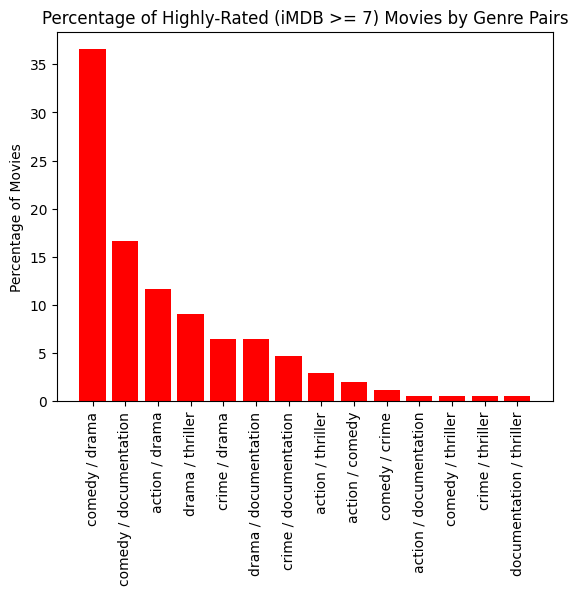

In [185]:
# Set x-axis
sorted_genre_groups = movies_group_df.groupby(["Popular Genres"]).size().sort_values(ascending=False)
x_axis = np.arange(len(sorted_genre_groups))

# Set y-axis
genre_sum = sorted_genre_groups.sum()
y_axis = [(g / genre_sum) * 100 for g in sorted_genre_groups]

# Graph the movie genre pairs percentages
plt.bar(x_axis, y_axis, color="red")
plt.xticks(x_axis, sorted_genre_groups.index, rotation=90)
plt.title(f"Percentage of Highly-Rated (iMDB >= {min_rating}) Movies by Genre Pairs")
plt.ylabel("Percentage of Movies")
plt.show()

In [186]:
# Shows Only

# Create DataFrame with only shows and add new column
shows_group_df = condensed_df.loc[condensed_df["type"] == "SHOW"]
shows_group_df["Popular Genres"] = ""

# Iterate over all shows
for index, row in shows_group_df.iterrows():
    # Turn the genres string into a sorted list
    genre_list = makeList(row["genres"])
    genre_list.sort()

    # Variables
    contains_genre = False
    popular_genres_string = ""

    # Iterate over genres we're searching for
    # If it exists, add it to string
    for genre in popular_genres:
        if genre in genre_list:
            popular_genres_string = popular_genres_string + genre + " / "
            contains_genre = True
    
    # Remove " / " at end of string
    popular_genres_string = popular_genres_string[:-3]
    
    # If exactly 2 genres were found in the list, add them to the new column
    # Otherwise, drop the row
    if contains_genre:
        if(popular_genres_string.count("/") == 0 or popular_genres_string.count("/") > 1):
            shows_group_df.drop(index, inplace=True)
        else:
            shows_group_df.at[index, "Popular Genres"] = popular_genres_string
    else:
        shows_group_df.drop(index, inplace=True)

#shows_group_df

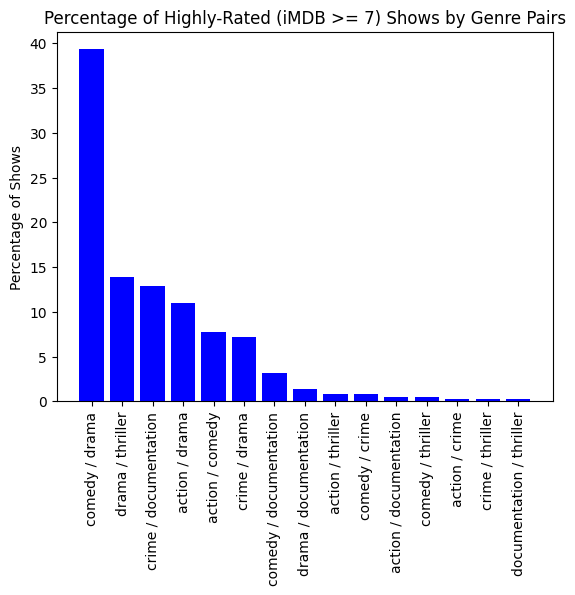

In [187]:
# Set x-axis
sorted_genre_groups = shows_group_df.groupby(["Popular Genres"]).size().sort_values(ascending=False)
x_axis = np.arange(len(sorted_genre_groups))

# Set y-axis
genre_sum = sorted_genre_groups.sum()
y_axis = [(g / genre_sum) * 100 for g in sorted_genre_groups]

# Graph the show genre pairs percentages
plt.bar(x_axis, y_axis, color="blue")
plt.xticks(x_axis, sorted_genre_groups.index, rotation=90)
plt.title(f"Percentage of Highly-Rated (iMDB >= {min_rating}) Shows by Genre Pairs")
plt.ylabel("Percentage of Shows")
plt.show()